# Proyecto Final: Comparación de Métodos de Fine-tuning

**Autor:** [Tu Nombre]  
**Fecha:** Diciembre 2025  
**Curso:** [Nombre del Curso]  

---

## Resumen Ejecutivo

Este proyecto evalúa diferentes métodos de fine-tuning para modelos de lenguaje, comparando:
- **Fine-tuning completo** (base_qa)
- **LoRA** (Low-Rank Adaptation)
- **QLoRA** (Quantized LoRA)
- **DoRA** (Weight-Decomposed Low-Rank Adaptation)
- **QDoRA** (Quantized DoRA)

Se analizaron múltiples configuraciones variando:
- Número de épocas (2 y 3)
- Learning rates (2e-4, 4.25e-5)

Los resultados se evaluaron usando las métricas F1-Score y Exact Match.

## 1. Configuración del Entorno

In [1]:
# Importar librerías necesarias
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Configuración de visualización
plt.rcParams.update({
    "font.size": 11,
    "figure.figsize": (10, 6),
    "axes.grid": True,
    "grid.alpha": 0.3
})
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## 2. Funciones de Utilidad (CORREGIDAS)

In [2]:
def find_experiment_folder(base_path, keyword):
    """
    Busca la carpeta de un experimento por palabra clave.
    Búsqueda flexible: 'lora' encuentra 'lora-epoch-2_lr_2e-4'
    """
    if base_path is None or not os.path.exists(base_path):
        return None
    
    # Intentar coincidencia exacta primero
    exact_path = os.path.join(base_path, keyword)
    if os.path.exists(exact_path):
        return exact_path
    
    # Buscar por palabra clave (case-insensitive)
    for d in os.listdir(base_path):
        if keyword.lower() in d.lower():
            return os.path.join(base_path, d)
    
    return None


def load_metrics_from_trainer_state(exp_path):
    """
    Carga métricas desde trainer_state.json.
    Busca en el último checkpoint.
    """
    if exp_path is None or not os.path.exists(exp_path):
        return None
    
    # Buscar checkpoints
    checkpoints = [
        os.path.join(exp_path, d)
        for d in os.listdir(exp_path)
        if d.startswith("checkpoint")
    ]
    
    if not checkpoints:
        # Intentar en la raíz
        trainer_state = os.path.join(exp_path, "trainer_state.json")
        if not os.path.exists(trainer_state):
            return None
    else:
        # Usar último checkpoint
        ckpt = sorted(checkpoints)[-1]
        trainer_state = os.path.join(ckpt, "trainer_state.json")
        if not os.path.exists(trainer_state):
            return None
    
    try:
        with open(trainer_state) as f:
            state = json.load(f)
        
        eval_logs = [l for l in state["log_history"] if "eval_f1" in l]
        
        if not eval_logs:
            return None
        
        last = eval_logs[-1]
        return {
            "F1": last["eval_f1"],
            "EM": last["eval_exact_match"]
        }
    except:
        return None


def training_time_from_tensorboard(exp_path):
    """
    Calcula tiempo desde TensorBoard.
    CORREGIDO: Usa rutas absolutas.
    """
    if exp_path is None or not os.path.exists(exp_path):
        return None
    
    event_files = []
    for root, _, files in os.walk(exp_path):
        for f in files:
            if "tfevents" in f:
                event_files.append(root)
                break
    
    if not event_files:
        return None
    
    try:
        # CLAVE: Usar ruta absoluta
        event_dir_abs = os.path.abspath(event_files[0])
        ea = EventAccumulator(event_dir_abs)
        ea.Reload()
        
        times = []
        for tag in ea.Tags().get("scalars", []):
            for e in ea.Scalars(tag):
                times.append(e.wall_time)
        
        if len(times) < 2:
            return None
        
        return max(times) - min(times)
    except:
        return None


def training_time_from_files(exp_path):
    """
    Calcula tiempo desde timestamps de archivos.
    Fallback cuando TensorBoard no está disponible.
    """
    if exp_path is None or not os.path.exists(exp_path):
        return None
    
    checkpoints = [
        os.path.join(exp_path, d)
        for d in os.listdir(exp_path)
        if d.startswith("checkpoint")
    ]
    
    if not checkpoints:
        return None
    
    ckpt = sorted(checkpoints)[-1]
    times = []
    
    for root, _, files in os.walk(ckpt):
        for f in files:
            try:
                times.append(os.path.getmtime(os.path.join(root, f)))
            except:
                continue
    
    if len(times) < 2:
        return None
    
    return max(times) - min(times)


def training_time_hybrid(exp_path):
    """
    Función híbrida: intenta TensorBoard primero, luego files.
    RECOMENDADO: Esta es la más robusta.
    """
    time_tb = training_time_from_tensorboard(exp_path)
    if time_tb is not None:
        return time_tb
    return training_time_from_files(exp_path)

## 3. Configuración de Ruta y Experimentos

In [3]:
# RUTA CORRECTA (ajustada según tu sistema)
LARGE_RESULTS = "/data/nina/qa_squad/qa_bertimbau/bertimbau_large/results"

# Verificar que existe
print(f"Ruta configurada: {LARGE_RESULTS}")
print(f"¿Existe?: {os.path.exists(LARGE_RESULTS)}")

if os.path.exists(LARGE_RESULTS):
    exp_count = len([d for d in os.listdir(LARGE_RESULTS) if os.path.isdir(os.path.join(LARGE_RESULTS, d))])
    print(f"✓ Experimentos disponibles: {exp_count}")
else:
    print(" ERROR: La ruta no existe. Ajusta LARGE_RESULTS.")

Ruta configurada: /data/nina/qa_squad/qa_bertimbau/bertimbau_large/results
¿Existe?: True
✓ Experimentos disponibles: 23


## 4. Definición de Experimentos (NOMBRES EXACTOS)

In [10]:
# Diccionario con TODOS los experimentos
# Nombres verificados según la estructura de tu carpeta

experiments = {
    # large QA (2 epochs)
    "Large QA - 2 epochs (lr=2e-4)": "2_epochs_large_qa-2e-4",
    "Large QA - 2 epochs (lr=4.25e-5)": "2_epochs_large_qa-4.25e-05",
    
    # large QA (3 epochs)
    "Large QA - 3 epochs (lr=2e-4)": "3_epochs_large_qa-2e-4",
    "Large QA - 3 epochs (lr=4.25e-5)": "3_epochs_large_qa-4.25e-05",
    
    # DoRA (nombres exactos)
    "DoRA - 2 epochs (lr=2e-4)": "dora_epoch-2_lr_2e-4",
    "DoRA - 2 epochs (lr=4.25e-5)": "dora_epoch-2_lr_4.25e-05",
    "DoRA - 3 epochs (lr=2e-4)": "dora_epoch-3_lr_2e-4",
    "DoRA - 3 epochs (lr=4.25e-5)": "dora_epoch-3_lr_4.25e-05",
    
    # QDoRA (nombres exactos)
    "QDoRA - 2 epochs (lr=2e-4)": "qdora_epoch-2_lr_2e-4",
    "QDoRA - 2 epochs (lr=4.25e-5)": "qdora_epoch-2_lr_4.25e-05",
    "QDoRA - 3 epochs (lr=2e-4)": "qdora_epoch-3_lr_2e-4",
    "QDoRA - 3 epochs (lr=4.25e-5)": "qdora_epoch-3_lr_4.25e-05",
    
    # LoRA epochs
    "LoRA - 2 epochs (lr=2e-4)": "lora_epoch-2_lr_2e-4",
    "LoRA - 2 epochs (lr=4.25e-5)": "lora_epoch-2_lr_4.25e-05",
    "LoRA - 3 epochs (lr=2e-4)": "lora_epoch-3_lr_2e-4",
    "LoRA - 3 epochs (lr=4.25e-5)": "lora_epoch-3_lr_4.25e-05",
    
    # QLoRA
    "QLoRA - 2 epochs (lr=2e-4)": "qlora_epoch-2_lr_2e-4",
    "QLoRA - 2 epochs (lr=4.25e-5)": "qlora_epoch-2_lr_4.25e-05",
    "QLoRA - 3 epochs (lr=2e-4)": "qlora_epoch-3_lr_2e-4",
    "QLoRA - 3 epochs (lr=4.25e-5)": "qlora_epoch-3_lr_4.25e-05"
}

print(f"Total de experimentos definidos: {len(experiments)}")

Total de experimentos definidos: 20


## 5. Recopilación de Resultados

In [11]:
# Recopilar métricas de todos los experimentos
rows = []

print("Recopilando datos...\n")
for name, key in experiments.items():
    exp_path = find_experiment_folder(LARGE_RESULTS, key)
    
    if exp_path is None:
        print(f"✗ {name}: No encontrado")
        continue
    
    metrics = load_metrics_from_trainer_state(exp_path)
    
    if metrics is None:
        print(f"⚠ {name}: Sin métricas")
        continue
    
    # Usar función híbrida para tiempo
    time_sec = training_time_hybrid(exp_path)
    
    rows.append({
        "Method": name,
        "F1": round(metrics["F1"], 2),
        "Exact Match": round(metrics["EM"], 2),
        "Training Time (min)": round(time_sec / 60, 1) if time_sec else None
    })
    
    print(f"✓ {name}: F1={metrics['F1']:.2f}, EM={metrics['EM']:.2f}")

df_results = pd.DataFrame(rows)

print(f"\n{'='*80}")
print(f"✓ Total recopilado: {len(df_results)} de {len(experiments)} experimentos")
print(f"{'='*80}")

Recopilando datos...

✓ Large QA - 2 epochs (lr=2e-4): F1=3.02, EM=0.03
✓ Large QA - 2 epochs (lr=4.25e-5): F1=84.86, EM=73.00
✓ Large QA - 3 epochs (lr=2e-4): F1=5.14, EM=0.11
✓ Large QA - 3 epochs (lr=4.25e-5): F1=83.74, EM=72.04
✓ DoRA - 2 epochs (lr=2e-4): F1=80.61, EM=68.09
✓ DoRA - 2 epochs (lr=4.25e-5): F1=74.93, EM=62.02
✓ DoRA - 3 epochs (lr=2e-4): F1=81.22, EM=68.70
✓ DoRA - 3 epochs (lr=4.25e-5): F1=77.18, EM=63.98
✓ QDoRA - 2 epochs (lr=2e-4): F1=77.96, EM=65.05
✓ QDoRA - 2 epochs (lr=4.25e-5): F1=70.32, EM=56.88
✓ QDoRA - 3 epochs (lr=2e-4): F1=79.61, EM=66.99
✓ QDoRA - 3 epochs (lr=4.25e-5): F1=71.24, EM=58.15
✓ LoRA - 2 epochs (lr=2e-4): F1=81.32, EM=68.67
✓ LoRA - 2 epochs (lr=4.25e-5): F1=75.65, EM=62.21
✓ LoRA - 3 epochs (lr=2e-4): F1=81.27, EM=68.67
✓ LoRA - 3 epochs (lr=4.25e-5): F1=81.28, EM=68.63
✓ QLoRA - 2 epochs (lr=2e-4): F1=80.03, EM=67.17
✓ QLoRA - 2 epochs (lr=4.25e-5): F1=68.23, EM=54.92
✓ QLoRA - 3 epochs (lr=2e-4): F1=80.28, EM=67.63
✓ QLoRA - 3 epochs (

## 6. Enriquecer Datos con Información Adicional

In [12]:
# Extraer información del nombre
def extract_method(name):
    if " - " in name:
        return name.split(" - ")[0]
    return name.split()[0]

def extract_epochs(name):
    if "2 epochs" in name:
        return 2
    elif "3 epochs" in name:
        return 3
    return None

def extract_lr(name):
    if "2e-4" in name:
        return "2e-4"
    elif "4.25e-5" in name or "4.25e-05" in name:
        return "4.25e-5"
    return None

# Aplicar
df_results['Método'] = df_results['Method'].apply(extract_method)
df_results['Épocas'] = df_results['Method'].apply(extract_epochs)
df_results['Learning Rate'] = df_results['Method'].apply(extract_lr)

# Renombrar
df_results = df_results.rename(columns={
    'Method': 'Experimento',
    'F1': 'F1-Score',
    'Training Time (min)': 'Tiempo (min)'
})

# Reordenar
column_order = ['Experimento', 'Método', 'Épocas', 'Learning Rate', 
                'F1-Score', 'Exact Match', 'Tiempo (min)']
df_results = df_results[column_order]

print("✓ Datos enriquecidos")
df_results.head(10)

✓ Datos enriquecidos


,Experimento,Método,Épocas,Learning Rate,F1-Score,Exact Match,Tiempo (min)
0,Large QA - 2 epochs (lr=2e-4),Large QA,2,2e-4,3.02,0.03,315.5
1,Large QA - 2 epochs (lr=4.25e-5),Large QA,2,4.25e-5,84.86,73.00,315.7
2,Large QA - 3 epochs (lr=2e-4),Large QA,3,2e-4,5.14,0.11,470.0
3,Large QA - 3 epochs (lr=4.25e-5),Large QA,3,4.25e-5,83.74,72.04,470.8
4,DoRA - 2 epochs (lr=2e-4),DoRA,2,2e-4,80.61,68.09,107.6
5,DoRA - 2 epochs (lr=4.25e-5),DoRA,2,4.25e-5,74.93,62.02,107.8
6,DoRA - 3 epochs (lr=2e-4),DoRA,3,2e-4,81.22,68.70,0.0
7,DoRA - 3 epochs (lr=4.25e-5),DoRA,3,4.25e-5,77.18,63.98,107.6
8,QDoRA - 2 epochs (lr=2e-4),QDoRA,2,2e-4,77.96,65.05,117.5
9,QDoRA - 2 epochs (lr=4.25e-5),QDoRA,2,4.25e-5,70.32,56.88,117.5


## 7. Tabla de Resultados Completa

In [13]:
# Ordenar por F1-Score
df_sorted = df_results.sort_values('F1-Score', ascending=False)
df_sorted

,Experimento,Método,Épocas,Learning Rate,F1-Score,Exact Match,Tiempo (min)
1,Large QA - 2 epochs (lr=4.25e-5),Large QA,2,4.25e-5,84.86,73.00,315.7
3,Large QA - 3 epochs (lr=4.25e-5),Large QA,3,4.25e-5,83.74,72.04,470.8
12,LoRA - 2 epochs (lr=2e-4),LoRA,2,2e-4,81.32,68.67,83.7
15,LoRA - 3 epochs (lr=4.25e-5),LoRA,3,4.25e-5,81.28,68.63,83.5
14,LoRA - 3 epochs (lr=2e-4),LoRA,3,2e-4,81.27,68.67,0.0
6,DoRA - 3 epochs (lr=2e-4),DoRA,3,2e-4,81.22,68.70,0.0
4,DoRA - 2 epochs (lr=2e-4),DoRA,2,2e-4,80.61,68.09,107.6
18,QLoRA - 3 epochs (lr=2e-4),QLoRA,3,2e-4,80.28,67.63,117.7
16,QLoRA - 2 epochs (lr=2e-4),QLoRA,2,2e-4,80.03,67.17,79.3
10,QDoRA - 3 epochs (lr=2e-4),QDoRA,3,2e-4,79.61,66.99,174.9


## 8. Análisis por Método

In [14]:
# Estadísticas por método
method_stats = df_results.groupby('Método').agg({
    'F1-Score': ['mean', 'std', 'min', 'max', 'count'],
    'Exact Match': ['mean', 'std', 'min', 'max'],
    'Tiempo (min)': ['mean', 'std', 'min', 'max']
}).round(2)

print("Estadísticas por Método:")
method_stats

Estadísticas por Método:


F1-Score                            Exact Match                       \
             mean    std    min    max count        mean    std    min    max   
Método                                                                          
DoRA        78.48   2.96  74.93  81.22     4       65.70   3.23  62.02  68.70   
Large QA    44.19  46.33   3.02  84.86     4       36.30  41.83   0.03  73.00   
LoRA        79.88   2.82  75.65  81.32     4       67.04   3.22  62.21  68.67   
QDoRA       74.78   4.69  70.32  79.61     4       61.77   5.00  56.88  66.99   
QLoRA       74.89   6.18  68.23  80.28     4       61.84   6.51  54.92  67.63   

         Tiempo (min)                       
                 mean    std    min    max  
Método                                      
DoRA            80.75  53.83    0.0  107.8  
Large QA       393.00  89.37  315.5  470.8  
LoRA            62.68  41.78    0.0   83.7  
QDoRA          146.32  33.28  117.5  175.4  
QLoRA           88.85  19.23   79.2  117.7

In [15]:
# Mejores configuraciones por método
best_configs = df_results.loc[df_results.groupby('Método')['F1-Score'].idxmax()]
best_configs = best_configs[['Método', 'Épocas', 'Learning Rate', 'F1-Score', 'Exact Match', 'Tiempo (min)']]
best_configs = best_configs.sort_values('F1-Score', ascending=False)

print("\nMejores configuraciones por método:")
best_configs


Mejores configuraciones por método:


,Método,Épocas,Learning Rate,F1-Score,Exact Match,Tiempo (min)
1,Large QA,2,4.25e-5,84.86,73.00,315.7
12,LoRA,2,2e-4,81.32,68.67,83.7
6,DoRA,3,2e-4,81.22,68.70,0.0
18,QLoRA,3,2e-4,80.28,67.63,117.7
10,QDoRA,3,2e-4,79.61,66.99,174.9


## 9. Visualizaciones

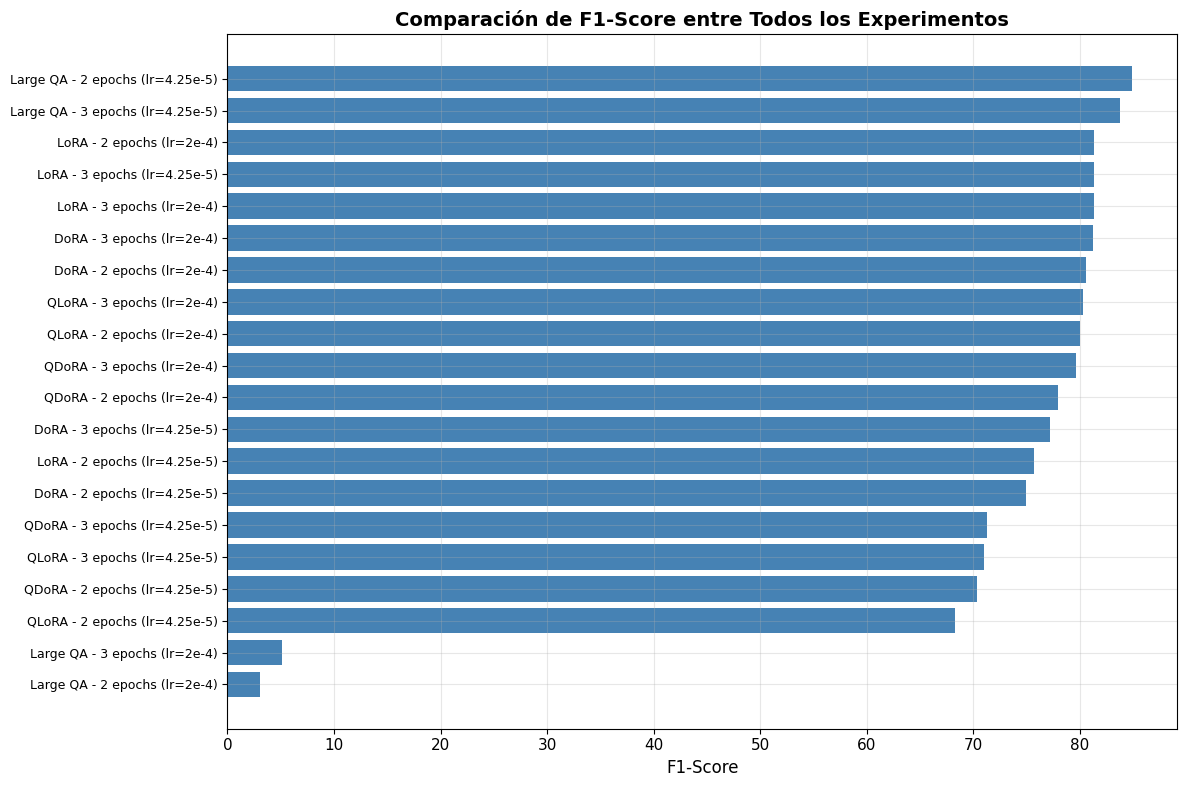

In [16]:
# Comparación de F1-Score
plt.figure(figsize=(12, 8))
df_plot = df_results.sort_values('F1-Score', ascending=True)
plt.barh(range(len(df_plot)), df_plot['F1-Score'], color='steelblue')
plt.yticks(range(len(df_plot)), df_plot['Experimento'], fontsize=9)
plt.xlabel('F1-Score', fontsize=12)
plt.title('Comparación de F1-Score entre Todos los Experimentos', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

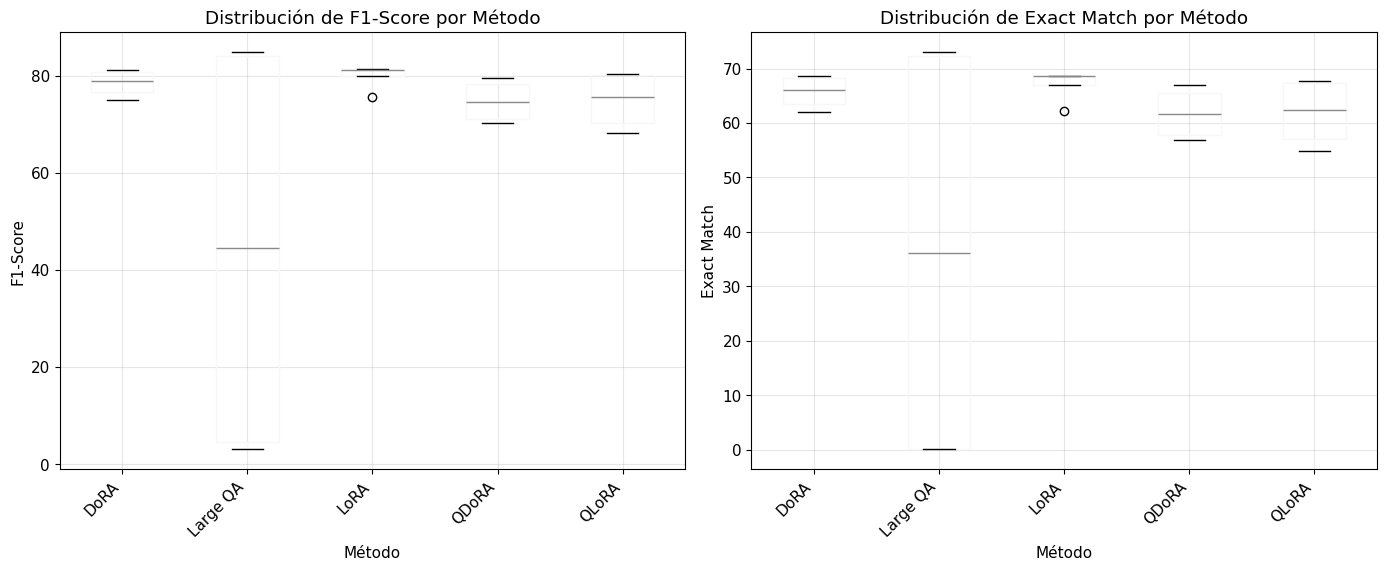

In [17]:
# Boxplot por método
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df_results.boxplot(column='F1-Score', by='Método', ax=axes[0])
axes[0].set_title('Distribución de F1-Score por Método')
axes[0].set_xlabel('Método')
axes[0].set_ylabel('F1-Score')
plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')

df_results.boxplot(column='Exact Match', by='Método', ax=axes[1])
axes[1].set_title('Distribución de Exact Match por Método')
axes[1].set_xlabel('Método')
axes[1].set_ylabel('Exact Match')
plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')

plt.suptitle('')
plt.tight_layout()
plt.show()

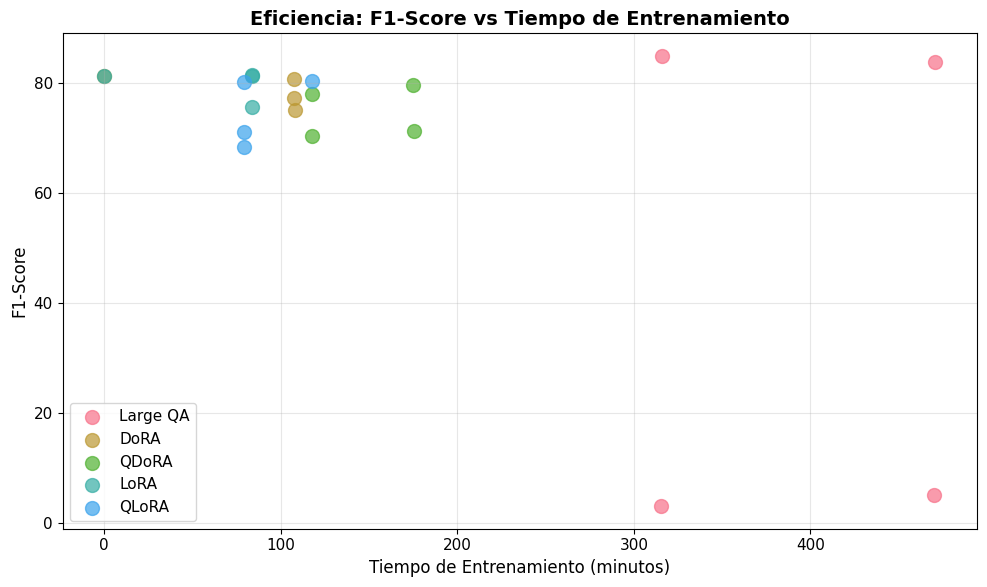

In [18]:
# F1-Score vs Tiempo
df_with_time = df_results[df_results['Tiempo (min)'].notna()]

if len(df_with_time) > 0:
    plt.figure(figsize=(10, 6))
    
    for method in df_with_time['Método'].unique():
        df_method = df_with_time[df_with_time['Método'] == method]
        plt.scatter(df_method['Tiempo (min)'], df_method['F1-Score'], 
                    label=method, s=100, alpha=0.7)
    
    plt.xlabel('Tiempo de Entrenamiento (minutos)', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title('Eficiencia: F1-Score vs Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de tiempo suficientes para graficar")

## 10. Top 5 Experimentos

In [ ]:
top_5 = df_results.nlargest(5, 'F1-Score')[['Experimento', 'Método', 'Épocas', 
                                               'Learning Rate', 'F1-Score', 
                                               'Exact Match', 'Tiempo (min)']]
print("\n Top 5 Experimentos (por F1-Score):")
print("=" * 80)
top_5


🏆 Top 5 Experimentos (por F1-Score):


,Experimento,Método,Épocas,Learning Rate,F1-Score,Exact Match,Tiempo (min)
1,Large QA - 2 epochs (lr=4.25e-5),Large QA,2,4.25e-5,84.86,73.00,315.7
3,Large QA - 3 epochs (lr=4.25e-5),Large QA,3,4.25e-5,83.74,72.04,470.8
12,LoRA - 2 epochs (lr=2e-4),LoRA,2,2e-4,81.32,68.67,83.7
15,LoRA - 3 epochs (lr=4.25e-5),LoRA,3,4.25e-5,81.28,68.63,83.5
14,LoRA - 3 epochs (lr=2e-4),LoRA,3,2e-4,81.27,68.67,0.0


## 11. Conclusiones

**[Completa esta sección después de analizar los resultados]**

In [ ]:
# Exportar resultados
df_results.to_csv('resultados_completos.csv', index=False)
best_configs.to_csv('mejores_configuraciones.csv', index=False)
method_stats.to_csv('estadisticas_por_metodo.csv')

print("✓ Resultados exportados:")
print("  - resultados_completos.csv")
print("  - mejores_configuraciones.csv")
print("  - estadisticas_por_metodo.csv")